In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/linear_OrnteinUhlenbeck`


In [2]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, Statistics, ProgressMeter, QuadGK, JLD2, OffsetArrays
using PowerLawSamplers: doubling_up_sampler
ProgressMeter.ijulia_behavior(:append)
using PyCall, Conda
mpl_toolkits = pyimport("mpl_toolkits.axes_grid1")
Line2D = pyimport("matplotlib.lines").Line2D
import PyPlot as plt
using LaTeXStrings

rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8

nx = pyimport("networkx")
function to_networkx(g::Graphs.AbstractGraph)
    g_nx = nx.Graph()
    for v in vertices(g)
        g_nx.add_node(Int(v))
    end
    for e in edges(g)
        g_nx.add_edge(Int(src(e)), Int(dst(e)))
    end
    return g_nx
end

fint(t, x, J, l, a) = sqrt(a^2 - x^2) / (1 - x^2) * exp(J * x * t) / (l - J * x)

function analytic_Ceq_RRG(t, K, J, lam, D)
    a = 2 * sqrt(K - 1) / K
    int, err = quadgk(x -> D * K * exp(- lam * t) / (2 * pi) * fint(t, x, J, lam, a), -a, a)
    return int
end

function analytic_Ceq_FC(t, J, lam, D)
    a = 2
    int, err = quadgk(x -> D * exp(- lam * t) / (2 * pi) * fint(t, x, J, lam, a), -a, a)
end

analytic_Ceq_FC (generic function with 1 method)

# Markov Chain Monte Carlo (MCMC)

## Single realization of disorder, stochasticity and initial conditions

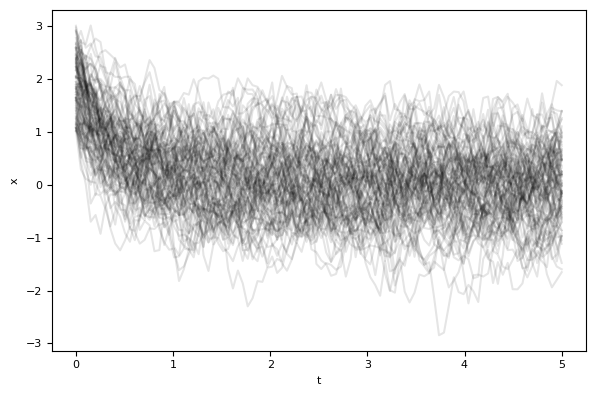

In [3]:
N, K = 100, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64) 
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = randn(rng) * sqrt(J)
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

model = OUModel(K, Jmat, lambdas, D)

x0_min, x0_max = 1.0, 3.0
x0 = rand(rng, N) * (x0_max - x0_min) .+ x0_min
tmax = 5.0 
tsave=collect(range(0.0, tmax; length=100))

tvec, trajs = sample_OU(model, x0, tmax, tsave; rng=rng)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
for i in 1:N
    ax.plot(tvec, view(trajs, i, :), color="k", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

display(fig)

## Average over disorder, noise realizations and initial conditions

In [4]:
N, K = 100, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0

x0_min, x0_max = 0.0, 1.0
dt_mc = 1e-3
tmax = 5.0
tsave = collect(range(0.0, tmax; step=dt_mc*100))

nsim = 100

# Define ensemble model
model_ensemble = OUModelRRG(N, K, J, lam, D, x0_min, x0_max)

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(model_ensemble, tmax, tsave, nsim; rng=rng, showprogress=true, dt=dt_mc);

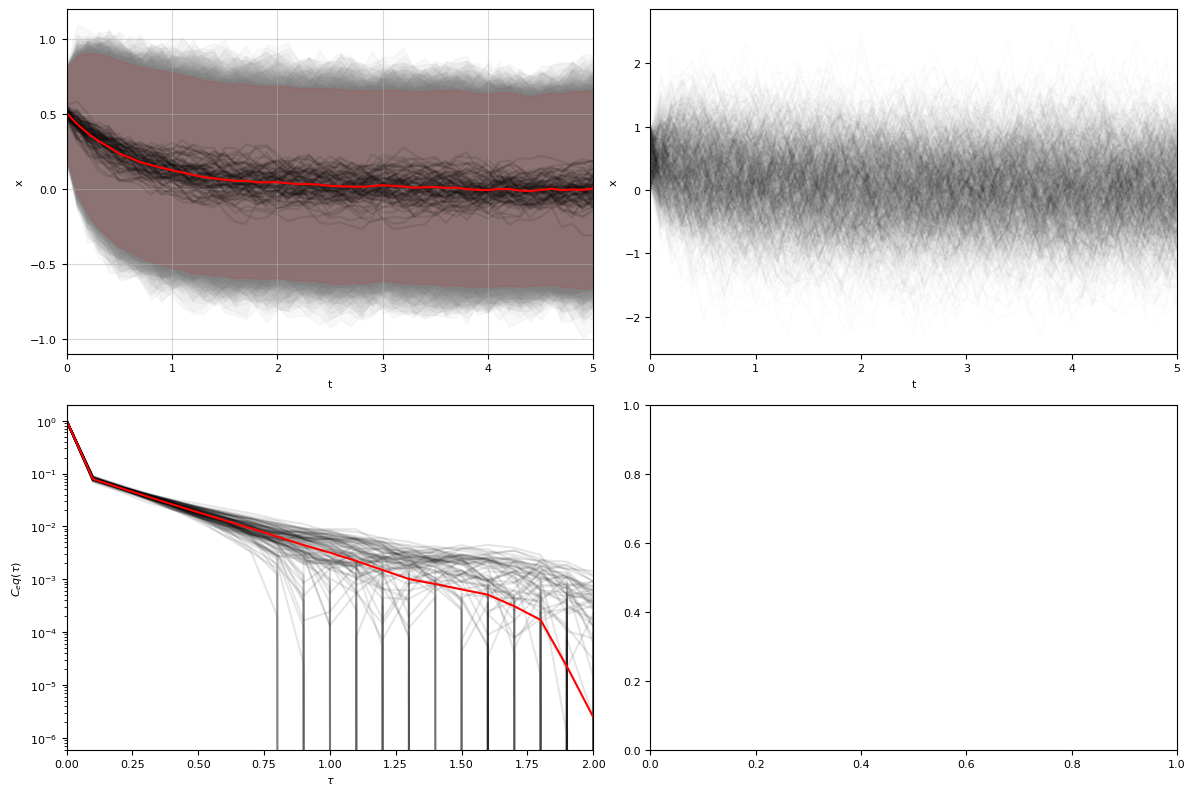

In [5]:
teq = 3.0
teq_idx = argmin(abs.(tsave .- teq))

fig, axs = plt.subplots(2, 2, figsize=(6*2, 4*2), tight_layout=true)

mean_traj, std_traj, t_idx_traj, autocorr_traj, err_autocorr_traj, l_idx_traj = compute_stats_TTI(traj_alls, teq_idx)
tvec_eq_traj = tsave[t_idx_traj]
lagvec_eq_traj = tsave[l_idx_traj .+ teq_idx] .- teq
# Only averages
for isim in 1:nsim
    mean, std, t_idx, autocorr, err_autocorr, l_idx = compute_stats_TTI(traj_alls[isim], teq_idx)
    tvec_eq = tsave[t_idx]
    lagvec_eq = tsave[l_idx .+ teq_idx] .- teq
    ax = axs[1,1]
    ax.plot(tvec_eq, mean, color="k", alpha=0.1)
    ax.fill_between(tvec_eq, mean .- std, mean .+ std, color="gray", alpha=0.05)
    ax = axs[2,1]
    ax.plot(lagvec_eq, autocorr ./ autocorr[1], color="k", alpha=0.1)
end
ax = axs[1,1]
ax.set_ylabel("x")
ax.set_xlabel("t")
ax.set_xlim(0, tmax)
ax.grid(alpha=0.5)
ax.plot(tvec_eq_traj, mean_traj, color="red")
ax.fill_between(tvec_eq_traj, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.1)
ax = axs[2,1]
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C_eq(\tau)")
ax.set_xlim(0, lagvec_eq_traj[end])
ax.set_yscale("log")
ax.plot(lagvec_eq_traj, autocorr_traj ./ autocorr_traj[1], color="red")


# Plot all trajectories
ax = axs[1,2]
ax.set_ylabel("x")
ax.set_xlabel("t")
ax.set_xlim(0, tmax)
for isim in 1:nsim
    for i in 1:10
        ax.plot(tvals_alls[isim], view(traj_alls[isim],i,:), color="k", alpha=0.01)
    end
end

plt.display(fig)

# GECaM approach

## Random Regular Graph with ferromagnetic interactions

In [6]:
N, K = 100, 4

rng = Xoshiro(1234)

lam, J, D = 1.5, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64) .* J
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 100.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

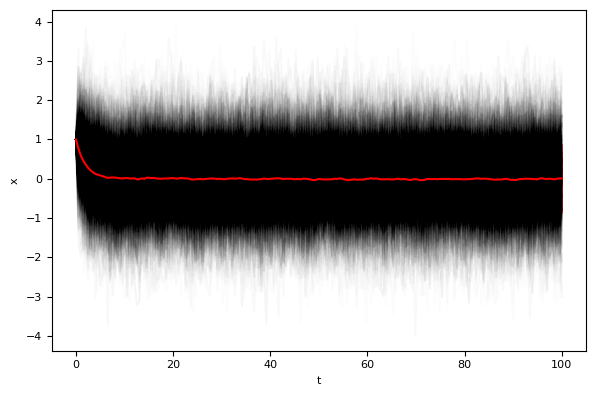

In [7]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [8]:
teq = 50.0
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-1

T_G = Int((tmax-teq)/dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

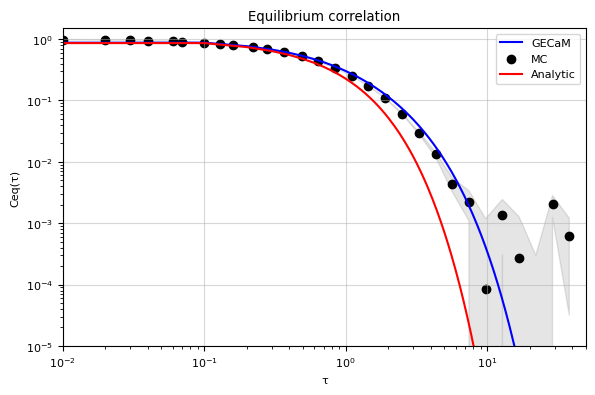

In [9]:
lagvec_mc = vcat(0.0, exp10.(collect(range(log10(1e-10), log10((tmax-teq)); length=100))))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

Ceq_analytic = zeros(T_G + 1)
for (idx, t) in enumerate(tvec_G)
    Ceq_analytic[idx] = analytic_Ceq_RRG(t, K, J, lam, D)
end

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.plot(tvec_G, Ceq_analytic ./ Ceq_analytic[1], color="red", label="Analytic")
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-5, 1.5)
ax.set_xlim(1e-2, 5e1)
ax.grid(alpha=.5)

plt.display(fig)   

## Erdos-Renyi with ferromagnetic interactions

In [10]:
N, K = 100, 4

rng = Xoshiro(1234)

lam, J, D = 1.7, 1.0/K, 1.0
G = erdos_renyi(N, K/N; rng=rng)
degs = degree(G)
Jmat = adjacency_matrix(G, Float64) .* J
lambdas = fill(lam, N)

x0_min, x0_max = -1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

teq1, teq2 = tmax - 30, 300.0
dt_mc = 1e-2
tmax = 500.0
tsave_mc = collect(range(teq2, tmax; step=1e-2))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

Progress: 100%|███████████████████████████| Time: 0:00:03 (30.08 ms/it)


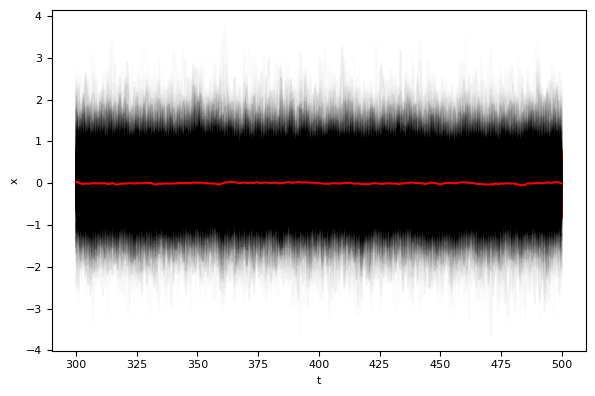

In [11]:
tvec_mc = collect(range(teq2, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [12]:
model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-1

T_G = Int((tmax - teq1) / dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

Cavity update: 100%|██████████████████████| Time: 0:00:22 ( 5.46 ns/it)
Marginal update: 100%|████████████████████| Time: 0:00:04 ( 4.58 ns/it)


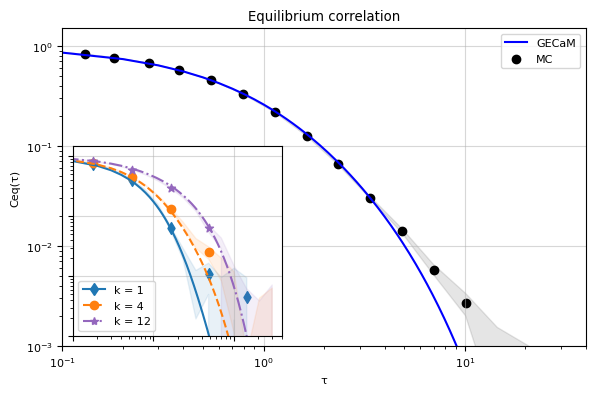

In [13]:
lagvec_mc = vcat(0.0, exp10.(collect(range(log10(3e-2), log10((3e1)); length=20))))
lagidxs_mc = [argmin(abs.(tsave_mc .- teq2 .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx] .- teq2

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-1, 4e1)
ax.grid(alpha=.5)
degmax = maximum(degs)
degmin = max(1, minimum(degs))
degs_plot = [degmin, K, degmax]
idxs_plot = [argmin(abs.(degs .- k)) for k in degs_plot]
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C4"]

lagvecs_mcdegs = []
Cs_degs = []
autocorrs_degs = []
err_autocorrs_degs = []

inset_ax = ax.inset_axes([0.02, 0.03, 0.4, 0.6]) 

custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"

for (idx_plot, k) in enumerate(degs_plot)
    idxk = idxs_plot[idx_plot]
    trajk = zeros(nsim, T_mc)
    @inbounds for (isim, traj) in enumerate(traj_alls)
        trajk[isim, :] .= traj[idxk, :]
    end
    autocorrk, err_autocorrk, l_idxk = compute_autocorr_TTI(trajk, 1; lag_indices=lagidxs_mc)
    lagvec_mck = tsave_mc[l_idxk] .- teq2

    # Plot both datasets
    inset_ax.plot(tvec_G, nodes[idxk].marg.C, color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvec_mck[1:3:end], autocorrk[1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvec_mck, autocorrk .- err_autocorrk, autocorrk .+ err_autocorrk, color=colors[idx_plot], alpha=0.1)

    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k = $k")

    # Store results if needed
    lagvecs_mcdegs = push!(lagvecs_mcdegs, lagvec_mck)
    Cs_degs = push!(Cs_degs, nodes[idxk].marg.C)
    autocorrs_degs = push!(autocorrs_degs, autocorrk)
    err_autocorrs_degs = push!(err_autocorrs_degs, err_autocorrk)
end

# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=8)

# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-1, 4e1)
inset_ax.grid(alpha=.5)

plt.display(fig)

## Random Configuration Model (RCM) with ferromagnetic interactions

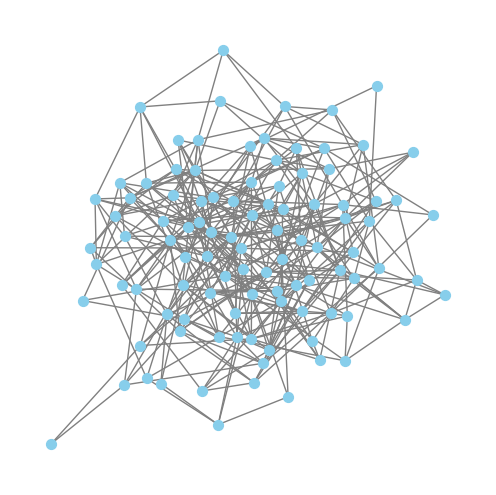

In [14]:
N, Ktarget = 100, 7
alpha = 2.5

rng = Xoshiro(1234)
G = static_scale_free(N, Int(Ktarget*N/2), alpha; rng=rng, finite_size_correction=true)
degs = degree(G)
K = mean(degs)
G_nx = to_networkx(G)

# Draw the graph using networkx and matplotlib
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=true)

layout = nx.spring_layout(G_nx, seed=42)
nx.draw(G_nx, pos=layout, ax=ax, with_labels=false, node_color="skyblue", edge_color="gray", node_size=50)
plt.display(fig)

In [15]:
lam, J, D = 3.0, 1.0/K, 1.0
Jmat = adjacency_matrix(G) .* J
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

teq1, teq2 = tmax - 30, 300.0
dt_mc = 1e-2
tmax = 500.0
tsave_mc = collect(range(teq2, tmax; step=1e-2))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

Progress: 100%|███████████████████████████| Time: 0:00:03 (35.26 ms/it)


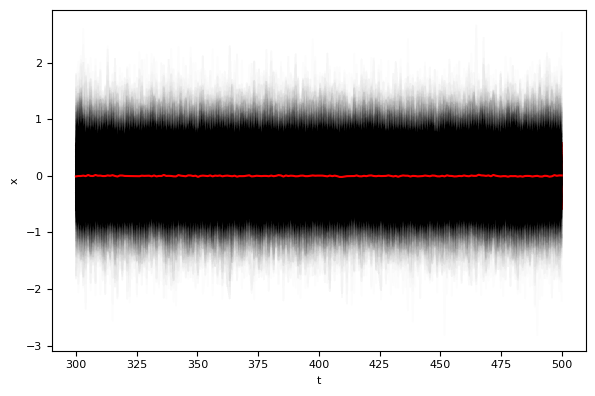

In [16]:
tvec_mc = collect(range(teq2, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [17]:
model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-1

T_G = Int((tmax - teq1) / dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

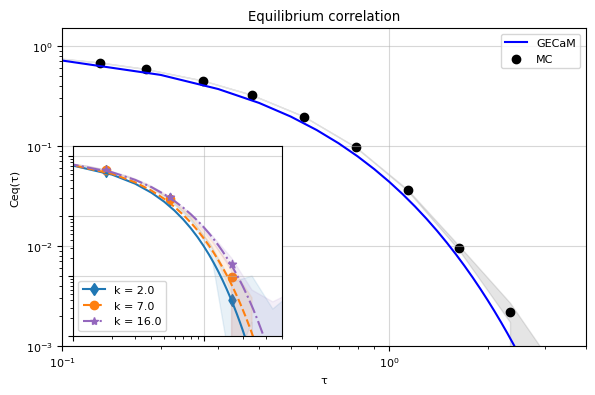

In [18]:
lagvec_mc = vcat(0.0, exp10.(collect(range(log10(3e-2), log10((3e1)); length=20))))
lagidxs_mc = [argmin(abs.(tsave_mc .- teq2 .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx] .- teq2

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-1, 4e0)
ax.grid(alpha=.5)
degmax = maximum(degs)
degmin = max(1, minimum(degs))
degs_plot = [degmin, K, degmax]
idxs_plot = [argmin(abs.(degs .- k)) for k in degs_plot]
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C4"]

lagvecs_mcdegs = []
Cs_degs = []
autocorrs_degs = []
err_autocorrs_degs = []

inset_ax = ax.inset_axes([0.02, 0.03, 0.4, 0.6]) 

custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"

for (idx_plot, k) in enumerate(degs_plot)
    idxk = idxs_plot[idx_plot]
    trajk = zeros(nsim, T_mc)
    @inbounds for (isim, traj) in enumerate(traj_alls)
        trajk[isim, :] .= traj[idxk, :]
    end
    autocorrk, err_autocorrk, l_idxk = compute_autocorr_TTI(trajk, 1; lag_indices=lagidxs_mc)
    lagvec_mck = tsave_mc[l_idxk] .- teq2

    # Plot both datasets
    inset_ax.plot(tvec_G, nodes[idxk].marg.C, color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvec_mck[1:3:end], autocorrk[1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvec_mck, autocorrk .- err_autocorrk, autocorrk .+ err_autocorrk, color=colors[idx_plot], alpha=0.1)

    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k = $k")

    # Store results if needed
    lagvecs_mcdegs = push!(lagvecs_mcdegs, lagvec_mck)
    Cs_degs = push!(Cs_degs, nodes[idxk].marg.C)
    autocorrs_degs = push!(autocorrs_degs, autocorrk)
    err_autocorrs_degs = push!(err_autocorrs_degs, err_autocorrk)
end

# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=8)

# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-1, 4e0)
inset_ax.grid(alpha=.5)

plt.display(fig)

## Random Regular Graph with disordered interactions (bimodal)

In [3]:
N, K = 200, 3

rng = Xoshiro(1234)

lam, J, D = 1.2, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64)
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = rand(rng) > 0.5 ? J : -J
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

x0_min, x0_max = 1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 300.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 500
teq = 200.0

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

Progress: 100%|███████████████████████████| Time: 0:00:49 ( 0.10  s/it)


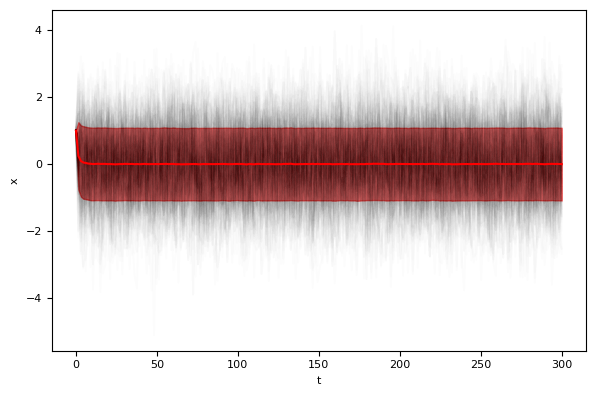

In [20]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 10)
    for i in rand(rng, 1:N, 20)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [4]:
teq_idx = argmin(abs.(tsave_mc .- teq))

model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-2

T_G = Int((tmax-teq)/dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

Cavity update: 100%|██████████████████████| Time: 0:02:42 ( 5.42 ns/it)
Marginal update: 100%|████████████████████| Time: 0:00:46 ( 4.63 ns/it)


In [ ]:
lagvec_mc = exp10.(collect(range(log10(1e-1), log10((tmax-teq)); length=100)))
lagidxs_mc = [argmin(abs.(view(tsave_mc,teq_idx:T_mc) .- teq .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, teq_idx; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-4, 1.5)
ax.set_xlim(1e-1, 5e1)
ax.grid(alpha=.5)

plt.display(fig)

## Erdos-Renyi with disordered interactions (bimodal)

In [50]:
N, K = 100, 4

rng = Xoshiro(1234)

lam, J, D = 1.3, 1.0/K, 1.0
Jmat = adjacency_matrix(erdos_renyi(N, K/N; rng=rng), Float64) 
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = rand(rng) > 0.5 ? J : -J
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

x0_min, x0_max = -1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

teq1, teq2 = tmax - 30, 300.0
dt_mc = 1e-2
tmax = 500.0
tsave_mc = collect(range(teq2, tmax; step=1e-2))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

Progress: 100%|███████████████████████████| Time: 0:00:02 (29.30 ms/it)


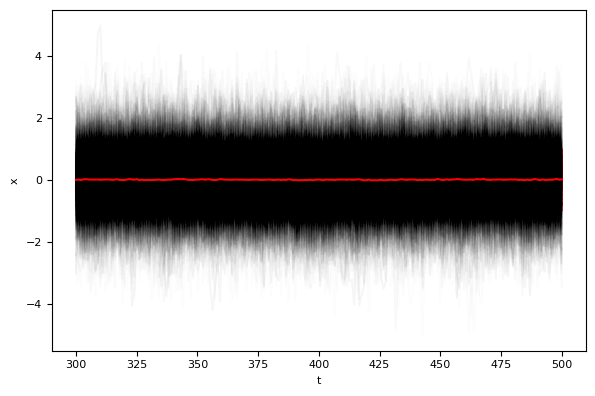

In [51]:
tvec_mc = collect(range(teq2, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [52]:
model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-1

T_G = Int((tmax - teq1) / dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

Cavity update: 100%|██████████████████████| Time: 0:00:06 ( 5.83 ns/it)
Marginal update: 100%|████████████████████| Time: 0:00:01 ( 4.80 ns/it)


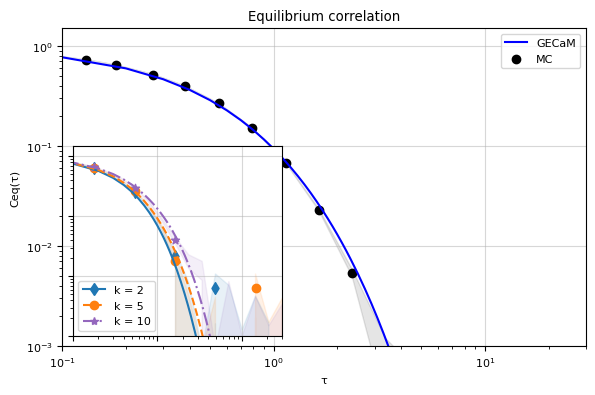

In [57]:
lagvec_mc = vcat(0.0, exp10.(collect(range(log10(3e-2), log10((3e1)); length=20))))
lagidxs_mc = [argmin(abs.(tsave_mc .- teq2 .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, 1; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx] .- teq2

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-1, 3e1)
ax.grid(alpha=.5)
degmax = maximum(degs)
degmin = max(1, minimum(degs))
degs_plot = [degmin, K, degmax]
idxs_plot = [argmin(abs.(degs .- k)) for k in degs_plot]
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C4"]

lagvecs_mcdegs = []
Cs_degs = []
autocorrs_degs = []
err_autocorrs_degs = []

inset_ax = ax.inset_axes([0.02, 0.03, 0.4, 0.6]) 

custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"

for (idx_plot, k) in enumerate(degs_plot)
    idxk = idxs_plot[idx_plot]
    trajk = zeros(nsim, T_mc)
    @inbounds for (isim, traj) in enumerate(traj_alls)
        trajk[isim, :] .= traj[idxk, :]
    end
    autocorrk, err_autocorrk, l_idxk = compute_autocorr_TTI(trajk, 1; lag_indices=lagidxs_mc)
    lagvec_mck = tsave_mc[l_idxk] .- teq2

    # Plot both datasets
    inset_ax.plot(tvec_G, nodes[idxk].marg.C, color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvec_mck[1:3:end], autocorrk[1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvec_mck, autocorrk .- err_autocorrk, autocorrk .+ err_autocorrk, color=colors[idx_plot], alpha=0.1)

    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k = $k")

    # Store results if needed
    lagvecs_mcdegs = push!(lagvecs_mcdegs, lagvec_mck)
    Cs_degs = push!(Cs_degs, nodes[idxk].marg.C)
    autocorrs_degs = push!(autocorrs_degs, autocorrk)
    err_autocorrs_degs = push!(err_autocorrs_degs, err_autocorrk)
end

# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=8)

# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-1, 3e1)
inset_ax.grid(alpha=.5)

plt.display(fig)

## Random Configuration Model (RCM) with disordered interactions (bimodal)

In [58]:
N, Ktarget = 100, 5
alpha = 2.7

rng = Xoshiro(1234)

G = static_scale_free(N, Int(Ktarget*N/2), alpha; rng=rng, finite_size_correction=true)
degs = degree(G)
K = floor(Int, mean(degs))

lam, J, D = 2.5, 1.0/K, 1.0
Jmat = adjacency_matrix(G, Float64)
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = rand(rng) > 0.5 ? J : -J
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

x0_min, x0_max = -1.0, 1.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

teq1, teq2 = tmax - 30, 300.0
dt_mc = 1e-2
tmax = 500.0
tsave_mc = collect(range(teq2, tmax; step=1e-2))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

Progress: 100%|███████████████████████████| Time: 0:00:03 (30.24 ms/it)


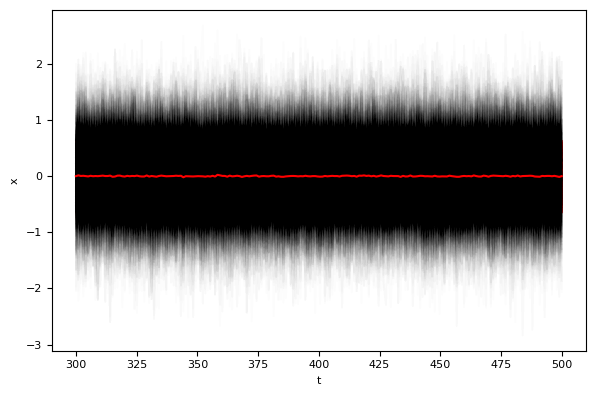

In [59]:
tvec_mc = collect(range(teq2, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [60]:
model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-1

T_G = Int((tmax - teq1) / dt_G)
nodes = run_cavity_EQ(model, dt_G, T_G; showprogress=true)

C, R = compute_averages(nodes, model, T_G);

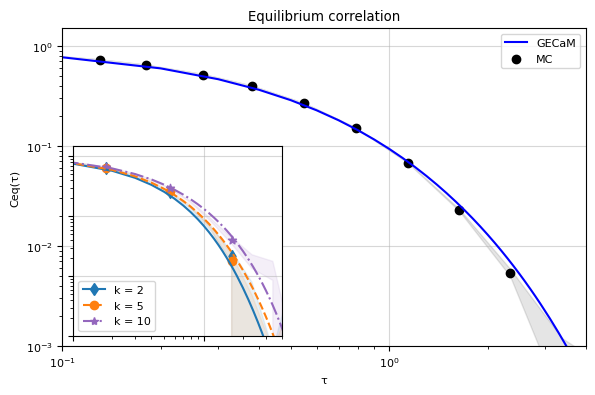

In [61]:
lagvec_mc = vcat(0.0, exp10.(collect(range(log10(3e-2), log10((3e1)); length=20))))
lagidxs_mc = [argmin(abs.(tsave_mc .- teq2 .- t)) for t in lagvec_mc] 
# Remvoe duplicates
lagidxs_mc = unique(lagidxs_mc)
lagvec_mc = tsave_mc[lagidxs_mc]

tvec_G = collect(range(0, T_G*dt_G, length=T_G + 1))

autocorr_traj, err_autocorr_traj, l_idx = compute_autocorr_TTI(traj_alls, 1; lag_indices=lagidxs_mc)
lagvec_mc = tsave_mc[l_idx] .- teq2

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend()
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-1, 4e0)
ax.grid(alpha=.5)
degmax = maximum(degs)
degmin = max(1, minimum(degs))
degs_plot = [degmin, K, degmax]
idxs_plot = [argmin(abs.(degs .- k)) for k in degs_plot]
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C4"]

lagvecs_mcdegs = []
Cs_degs = []
autocorrs_degs = []
err_autocorrs_degs = []

inset_ax = ax.inset_axes([0.02, 0.03, 0.4, 0.6]) 

custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"

for (idx_plot, k) in enumerate(degs_plot)
    idxk = idxs_plot[idx_plot]
    trajk = zeros(nsim, T_mc)
    @inbounds for (isim, traj) in enumerate(traj_alls)
        trajk[isim, :] .= traj[idxk, :]
    end
    autocorrk, err_autocorrk, l_idxk = compute_autocorr_TTI(trajk, 1; lag_indices=lagidxs_mc)
    lagvec_mck = tsave_mc[l_idxk] .- teq2

    # Plot both datasets
    inset_ax.plot(tvec_G, nodes[idxk].marg.C, color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvec_mck[1:3:end], autocorrk[1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvec_mck, autocorrk .- err_autocorrk, autocorrk .+ err_autocorrk, color=colors[idx_plot], alpha=0.1)

    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k = $k")

    # Store results if needed
    lagvecs_mcdegs = push!(lagvecs_mcdegs, lagvec_mck)
    Cs_degs = push!(Cs_degs, nodes[idxk].marg.C)
    autocorrs_degs = push!(autocorrs_degs, autocorrk)
    err_autocorrs_degs = push!(err_autocorrs_degs, err_autocorrk)
end

# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=8)

# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-1, 4e0)
inset_ax.grid(alpha=.5)

plt.display(fig)

## Plot all together

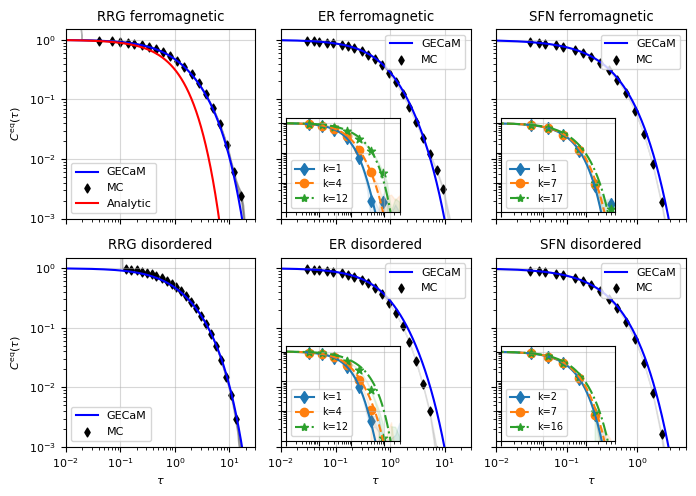

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(7, 5), tight_layout=true, sharey=true)

# RRG Ferro
ax = axs[1, 1]
# Parameters
N, K = 200, 3
lam, J, D = 1.2, 1.0/K, 1.0
tmax = 300.0
nsim = 500
teq = 200.0
# Load data
jldfile = "data/RRG_Ferro/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C, Ceq_analytic = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C", "Ceq_analytic")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.plot(tvec_G, Ceq_analytic ./ Ceq_analytic[1], color="red", label="Analytic")
ax.legend()
ax.set_ylabel(L"C^{\rm eq}(\tau)")
ax.set_title("RRG ferromagnetic")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-2, 3e1)
ax.tick_params(labelbottom=false)
ax.grid(alpha=.5)

# ER ferro
ax = axs[1, 2]
# Parameters
N, K = 100, 4
lam, J, D = 1.7, 1.0/K, 1.0
tmax = 500.0
nsim = 500
teq1, teq2 = 470, 150
# Load data
jldfile = "data/ER_Ferro/plots/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq1-$(teq1)_teq2-$(teq2).jld2"
tvec_G, C, lagvec_mc, autocorr_traj, err_autocorr_traj, lagvecs_mcdegs, Cs_degs, autocorrs_degs, err_autocorrs_degs, degs_plot = load(jldfile, "tvec_G", "C", "lagvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvecs_mcdegs", "Cs_degs", "autocorrs_degs", "err_autocorrs_degs", "degs_plot")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend(loc="upper right")
ax.set_title("ER ferromagnetic")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-2, 3e1)
ax.set_ylim(1e-3, 1.5)
ax.tick_params(labelbottom=false)
ax.grid(alpha=.5)
# Plot inset
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C2"]
inset_ax = ax.inset_axes([0.026, 0.032, 0.6, 0.5]) 
custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"    
for (idx_plot, k) in enumerate(degs_plot)
    # Plot both datasets
    inset_ax.plot(tvec_G, Cs_degs[idx_plot], color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvecs_mcdegs[idx_plot][1:3:end], autocorrs_degs[idx_plot][1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvecs_mcdegs[idx_plot], autocorrs_degs[idx_plot] .- err_autocorrs_degs[idx_plot], autocorrs_degs[idx_plot] .+ err_autocorrs_degs[idx_plot], color=colors[idx_plot], alpha=0.1)
    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k=$k")
end
# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=7)
# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-2, 3e1)
inset_ax.grid(alpha=.5)


# RCM ferro
ax = axs[1, 3]
# Parameters
N, K = 200, 7
alpha = 2.5
lam, J, D = 3.0, 1.0/K, 1.0
tmax = 500.0
nsim = 1000
teq1, teq2 = 470, 150
# Load data
jldfile = "data/RCM_Ferro/plots/N-$(N)_K-$(K)_alpha-$(alpha)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq1-$(teq1)_teq2-$(teq2).jld2"
tvec_G, C, lagvec_mc, autocorr_traj, err_autocorr_traj, lagvecs_mcdegs, Cs_degs, autocorrs_degs, err_autocorrs_degs, degs_plot = load(jldfile, "tvec_G", "C", "lagvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvecs_mcdegs", "Cs_degs", "autocorrs_degs", "err_autocorrs_degs", "degs_plot")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend(loc="upper right")
ax.set_title("SFN ferromagnetic")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-2, 5e0)
ax.grid(alpha=.5)
ax.tick_params(labelbottom=false)
# Plot inset
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C2"]
inset_ax = ax.inset_axes([0.026, 0.032, 0.6, 0.5]) 
custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"    
for (idx_plot, k) in enumerate(degs_plot)
    # Plot both datasets
    inset_ax.plot(tvec_G, Cs_degs[idx_plot], color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvecs_mcdegs[idx_plot][1:3:end], autocorrs_degs[idx_plot][1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvecs_mcdegs[idx_plot], autocorrs_degs[idx_plot] .- err_autocorrs_degs[idx_plot], autocorrs_degs[idx_plot] .+ err_autocorrs_degs[idx_plot], color=colors[idx_plot], alpha=0.1)
    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k=$k")
end
# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=7)
# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-2, 5e0)
inset_ax.grid(alpha=.5)

# RRG disordered
ax = axs[2, 1]
# Parameters
N, K = 200, 3
lam, J, D = 1.2, 1.0/K, 1.0
tmax = 300.0
nsim = 500
teq = 200.0
# Load data
jldfile = "data/RRG_Dis_Bim/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.legend()
ax.set_ylabel(L"C^{\rm eq}(\tau)")
ax.set_xlabel(L"\tau")
ax.set_title("RRG disordered")
ax.set_xlim(1e-2, 3e1)
ax.set_ylim(1e-3, 1.5)
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=.5)


# ER disordered
ax = axs[2, 2]
# Parameters
N, K = 100, 4
lam, J, D = 1.7, 1.0/K, 1.0
tmax = 500.0
nsim = 500
teq1, teq2 = 470, 150
# Load data
jldfile = "data/ER_Dis_Bim/plots/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq1-$(teq1)_teq2-$(teq2).jld2"
tvec_G, C, lagvec_mc, autocorr_traj, err_autocorr_traj, lagvecs_mcdegs, Cs_degs, autocorrs_degs, err_autocorrs_degs, degs_plot = load(jldfile, "tvec_G", "C", "lagvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvecs_mcdegs", "Cs_degs", "autocorrs_degs", "err_autocorrs_degs", "degs_plot")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend(loc="upper right")
ax.set_title("ER disordered")
ax.set_xlabel(L"\tau")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-2, 3e1)
ax.set_ylim(1e-3, 1.5)
ax.grid(alpha=.5)
# Plot inset
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C2"]
inset_ax = ax.inset_axes([0.026, 0.032, 0.6, 0.5]) 
custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"    
for (idx_plot, k) in enumerate(degs_plot)
    # Plot both datasets
    inset_ax.plot(tvec_G, Cs_degs[idx_plot], color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvecs_mcdegs[idx_plot][1:3:end], autocorrs_degs[idx_plot][1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvecs_mcdegs[idx_plot], autocorrs_degs[idx_plot] .- err_autocorrs_degs[idx_plot], autocorrs_degs[idx_plot] .+ err_autocorrs_degs[idx_plot], color=colors[idx_plot], alpha=0.1)
    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k=$k")
end
# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=7)
# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-2, 3e1)
inset_ax.grid(alpha=.5)


# RCM disordered
ax = axs[2, 3]
# Parameters
N, K = 100, 7
alpha = 2.5
lam, J, D = 3.0, 1.0/K, 1.0
tmax = 500.0
nsim = 1000
teq1, teq2 = 470, 150
# Load data
jldfile = "data/RCM_Dis_Bim/plots/N-$(N)_K-$(K)_alpha-$(alpha)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq1-$(teq1)_teq2-$(teq2).jld2"
tvec_G, C, lagvec_mc, autocorr_traj, err_autocorr_traj, lagvecs_mcdegs, Cs_degs, autocorrs_degs, err_autocorrs_degs, degs_plot = load(jldfile, "tvec_G", "C", "lagvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvecs_mcdegs", "Cs_degs", "autocorrs_degs", "err_autocorrs_degs", "degs_plot")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend(loc="upper right")
ax.set_title("SFN disordered")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(L"\tau")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-2, 5e0)
ax.grid(alpha=.5)
# Plot inset
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C2"]
inset_ax = ax.inset_axes([0.026, 0.032, 0.6, 0.5]) 
custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"    
for (idx_plot, k) in enumerate(degs_plot)
    # Plot both datasets
    inset_ax.plot(tvec_G, Cs_degs[idx_plot], color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvecs_mcdegs[idx_plot][1:3:end], autocorrs_degs[idx_plot][1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvecs_mcdegs[idx_plot], autocorrs_degs[idx_plot] .- err_autocorrs_degs[idx_plot], autocorrs_degs[idx_plot] .+ err_autocorrs_degs[idx_plot], color=colors[idx_plot], alpha=0.1)
    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k=$k")
end
# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=7)
# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-2, 5e0)
inset_ax.grid(alpha=.5)

plt.display(fig)

fig.savefig("Ceq_all.png", dpi=300, bbox_inches="tight")
fig.savefig("Ceq_all.pdf", bbox_inches="tight")

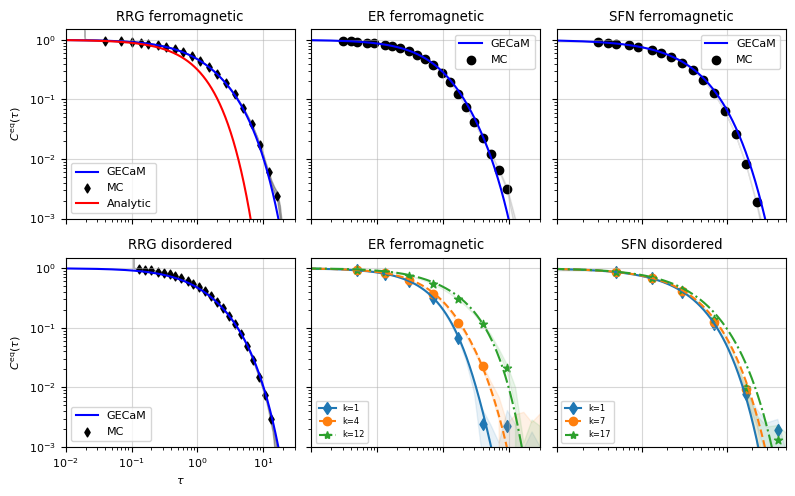

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), tight_layout=true, sharey=true)

# RRG Ferro
ax = axs[1, 1]
# Parameters
N, K = 200, 3
lam, J, D = 1.2, 1.0/K, 1.0
tmax = 300.0
nsim = 500
teq = 200.0
# Load data
jldfile = "data/RRG_Ferro/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C, Ceq_analytic = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C", "Ceq_analytic")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.plot(tvec_G, Ceq_analytic ./ Ceq_analytic[1], color="red", label="Analytic")
ax.legend()
ax.set_ylabel(L"C^{\rm eq}(\tau)")
ax.set_title("RRG ferromagnetic")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-2, 3e1)
ax.tick_params(labelbottom=false)
ax.grid(alpha=.5)

# ER ferro
ax = axs[1, 2]
# Parameters
N, K = 100, 4
lam, J, D = 1.7, 1.0/K, 1.0
tmax = 500.0
nsim = 500
teq1, teq2 = 470, 150
# Load data
jldfile = "data/ER_Ferro/plots/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq1-$(teq1)_teq2-$(teq2).jld2"
tvec_G, C, lagvec_mc, autocorr_traj, err_autocorr_traj, lagvecs_mcdegs, Cs_degs, autocorrs_degs, err_autocorrs_degs, degs_plot = load(jldfile, "tvec_G", "C", "lagvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvecs_mcdegs", "Cs_degs", "autocorrs_degs", "err_autocorrs_degs", "degs_plot")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend(loc="upper right")
ax.set_title("ER ferromagnetic")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-2, 3e1)
ax.set_ylim(1e-3, 1.5)
ax.tick_params(labelbottom=false)
ax.grid(alpha=.5)
# Plot inset
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C2"]
inset_ax = axs[2,2]
custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"    
for (idx_plot, k) in enumerate(degs_plot)
    # Plot both datasets
    inset_ax.plot(tvec_G, Cs_degs[idx_plot], color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvecs_mcdegs[idx_plot][1:3:end], autocorrs_degs[idx_plot][1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvecs_mcdegs[idx_plot], autocorrs_degs[idx_plot] .- err_autocorrs_degs[idx_plot], autocorrs_degs[idx_plot] .+ err_autocorrs_degs[idx_plot], color=colors[idx_plot], alpha=0.1)
    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k=$k")
end
# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=6)
# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-2, 3e1)
inset_ax.grid(alpha=.5)
inset_ax.set_title("ER ferromagnetic")


# RCM ferro
ax = axs[1, 3]
# Parameters
N, K = 200, 7
alpha = 2.5
lam, J, D = 3.0, 1.0/K, 1.0
tmax = 500.0
nsim = 1000
teq1, teq2 = 470, 150
# Load data
jldfile = "data/RCM_Ferro/plots/N-$(N)_K-$(K)_alpha-$(alpha)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq1-$(teq1)_teq2-$(teq2).jld2"
tvec_G, C, lagvec_mc, autocorr_traj, err_autocorr_traj, lagvecs_mcdegs, Cs_degs, autocorrs_degs, err_autocorrs_degs, degs_plot = load(jldfile, "tvec_G", "C", "lagvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvecs_mcdegs", "Cs_degs", "autocorrs_degs", "err_autocorrs_degs", "degs_plot")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc, autocorr_traj, color="black", label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.1)
ax.legend(loc="upper right")
ax.set_title("SFN ferromagnetic")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-3, 1.5)
ax.set_xlim(1e-2, 5e0)
ax.grid(alpha=.5)
ax.tick_params(labelbottom=false)
# Plot inset
mts = ["d", "o", "*"]
lts = ["-", "--", "-."]
colors = ["C0", "C1", "C2"]
inset_ax = axs[2,3]
custom_handles = PyObject[]  # Will store combined handles
custom_labels = String[]  # Will store single labels like "k = $k"    
for (idx_plot, k) in enumerate(degs_plot)
    # Plot both datasets
    inset_ax.plot(tvec_G, Cs_degs[idx_plot], color=colors[idx_plot], ls=lts[idx_plot])
    inset_ax.scatter(lagvecs_mcdegs[idx_plot][1:3:end], autocorrs_degs[idx_plot][1:3:end], marker=mts[idx_plot], color=colors[idx_plot])
    inset_ax.fill_between(lagvecs_mcdegs[idx_plot], autocorrs_degs[idx_plot] .- err_autocorrs_degs[idx_plot], autocorrs_degs[idx_plot] .+ err_autocorrs_degs[idx_plot], color=colors[idx_plot], alpha=0.1)
    # Create combined handle
    handle = Line2D([], [], color=colors[idx_plot], marker=mts[idx_plot], linestyle=lts[idx_plot])
    push!(custom_handles, handle)
    push!(custom_labels, "k=$k")
end
# Use custom legend
inset_ax.legend(custom_handles, custom_labels, loc="lower left", fontsize=6)
# Set inset axis properties
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelbottom=false, labelleft=false)
inset_ax.set_yscale("log")
inset_ax.set_xscale("log")
inset_ax.set_ylim(1e-3, 1.5)
inset_ax.set_xlim(1e-2, 5e0)
inset_ax.grid(alpha=.5)
inset_ax.set_title("SFN disordered")

# RRG disordered
ax = axs[2, 1]
# Parameters
N, K = 200, 3
lam, J, D = 1.2, 1.0/K, 1.0
tmax = 300.0
nsim = 500
teq = 200.0
# Load data
jldfile = "data/RRG_Dis_Bim/N-$(N)_K-$(K)_lam-$(lam)_D-$(D)_J-$(Int(J*K))_tmax-$(tmax)_nsim-$(nsim)_teq-$(teq).jld2"
tvec_mc, autocorr_traj, err_autocorr_traj, lagvec_mc, lagidxs_mc, tvec_G, C = load(jldfile, "tvec_mc", "autocorr_traj", "err_autocorr_traj", "lagvec_mc", "lagidxs_mc", "tvec_G", "C")
# Plot correlations
ax.plot(tvec_G, C, color="blue", label="GECaM")
ax.scatter(lagvec_mc[1:3:end], autocorr_traj[1:3:end], color="black", marker="d", s=20, label="MC")
ax.fill_between(lagvec_mc, autocorr_traj .- err_autocorr_traj, autocorr_traj .+ err_autocorr_traj, color="black", alpha=0.3)
ax.legend()
ax.set_ylabel(L"C^{\rm eq}(\tau)")
ax.set_xlabel(L"\tau")
ax.set_title("RRG disordered")
ax.set_xlim(1e-2, 3e1)
ax.set_ylim(1e-3, 1.5)
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=.5)

plt.display(fig)

fig.savefig("Ceq_all_degs.png", dpi=300, bbox_inches="tight")
fig.savefig("Ceq_all_degs.pdf", bbox_inches="tight")

# Comparison between sparse and fully connecyted 

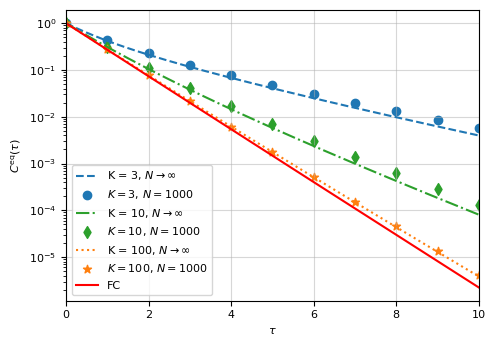

In [14]:
N = 1000

lam, J, D = 1.3, 1.0, 1.0
tmax = 10.0

jldfile = "data/RRG_Ferro/plots/compare_FC/N-$(N)_lam-$(lam)_D-$(D)_tmax-$(tmax).jld2"
Cs, tvec_G, Ks = load(jldfile, "Cs", "tvec_G", "Ks")

fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), tight_layout=true)

colors = ["C0", "C2", "C1", "red"]
lts = ["--", "-.", ":", "-"]
mts = ["o", "d", "*", "P"]
# Iterate over different K values
for (iK, K) in enumerate(Ks)
    
    # Plot correlations
    if K < N-1
        ax.plot(tvec_G, analytic_Ceq_RRG.(tvec_G, K, J, lam, D) ./ analytic_Ceq_RRG.(0, K, J, lam, D), color=colors[iK], label="K = $K, " * L"N \to \infty", ls=lts[iK])
        ax.scatter(tvec_G[1:100:end], Cs[iK][1:100:end] ./ Cs[iK][1], color=colors[iK], label=L"K="*"$K, "*L"N="*"$N", marker=mts[iK])
    else
        ax.plot(tvec_G, Cs[iK] ./ Cs[iK][1], color=colors[iK], label="FC", ls=lts[iK])
    end
end
ax.legend()
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C^{\rm eq}(\tau)")
ax.set_yscale("log")

ax.set_xlim(0, tmax)
#ax.set_ylim(, 1.5)
ax.grid(alpha=.5)

plt.display(fig)

fig.savefig("Compare_FC_Ceq.png", dpi=300, bbox_inches="tight")
fig.savefig("Compare_FC_Ceq.pdf", bbox_inches="tight")